# [ml4ir](https://github.com/salesforce/ml4ir) 
#### open source, modular, python3 library for IR based ML applications
--------------------

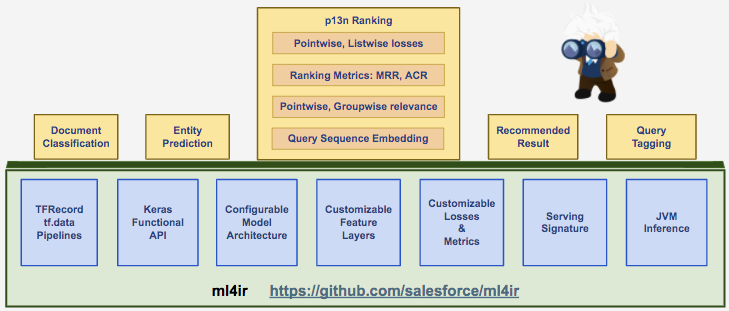

### First, let's load the data and take a look at it

In [ ]:
from ml4ir.io import file_io
import glob
import logging
import pandas as pd
import os

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setup logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("Logger is initialized...")


# Load data
CSV_DATA_DIR = '/Users/ashish.srinivasa/search_relevance/model_training/226/data/csv/seen_orgs/demo_Account/'

df = file_io.read_df_list(glob.glob(os.path.join(CSV_DATA_DIR, "train", "*.csv")), log=logger)

logger.info(df.shape)

df.head().T

### Let's define the feature configuration for our data

### ... brace yourselves!

In [ ]:
# Set up the feature configurations
from ml4ir.features.feature_config import parse_config
from ml4ir.features.feature_config import ExampleFeatureConfig
from ml4ir.config.keys import TFRecordTypeKey
import json

feature_config_yaml = '''
query_key: 
  name: query_id
  node_name: query_id
  trainable: false
  dtype: string
  log_at_inference: true
  feature_layer_info:
    type: string
  serving_info:
    name: query_id
    required: false
label:
  name: clicked
  node_name: clicked
  trainable: false
  dtype: float
  log_at_inference: true
  feature_layer_info:
    type: numeric
    shape: null
  serving_info:
    name: clicked
    required: false
features:
  - name: sim_score
    node_name: sim_score
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      name: sim_score
      required: true
  - name: p_OwnerId
    node_name: p_OwnerId
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
      fn: signed_log
      args:
        shift: 1
    serving_info:
      name: p_OwnerId
      required: true
  - name: la
    node_name: la
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      name: la
      required: true
    tfrecord_type: sequence
  - name: pv_s
    node_name: pv_s
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      name: pv_s
      required: true
    tfrecord_type: sequence
  - name: query_start
    node_name: query_start
    trainable: true
    dtype: string
    log_at_inference: true
    feature_layer_info:
      type: numeric
      shape: null
      fn: get_sequence_encoding
      args:
        encoding_type: bilstm
        encoding_size: 128
        embedding_size: 128
        max_length: 20
    preprocessing_info:
      - fn: preprocess_text
        args:
          remove_punctuation: true
          to_lower: true
      - fn: strip_numbers
    serving_info:
      required: true
      default_value: ""
      name: query_str
  - name: organization_id
    node_name: organization_id
    trainable: true
    dtype: string
    log_at_inference: true
    is_group_metric_key: true
    feature_layer_info:
      type: categorical
      fn: get_categorical_embedding
      args:
        num_categorical_features: 2
        num_hash_buckets: 32
        embedding_size: 32
        merge_mode: concat
    serving_info:
      name: organization_id
      required: false
      default_value: ""
  - name: fr
    node_name: fr
    trainable: false
    dtype: float
    log_at_inference: true
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      name: fr
      required: true
'''
feature_config: ExampleFeatureConfig = parse_config(TFRecordTypeKey.EXAMPLE, feature_config_yaml, logger=logger)
    
logging.info(json.dumps(feature_config.get_all_features(), indent=4))

## TFRecords - Examples vs SequenceExamples

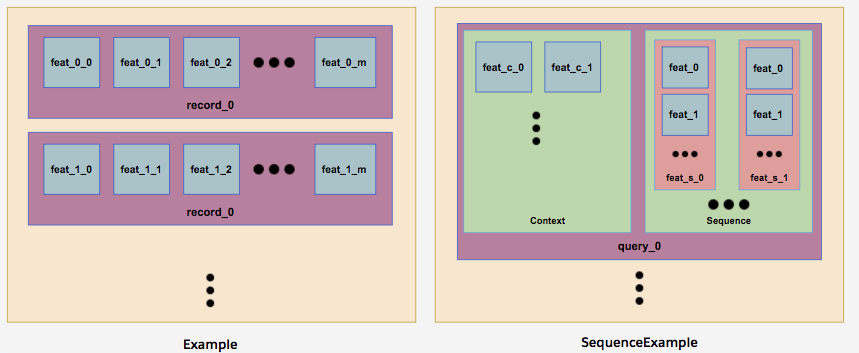

### Time to load the data and save awesome TFRecords

In [ ]:
from ml4ir.io import file_io
from ml4ir.data import tfrecord_writer
import glob

# Load data
df = file_io.read_df_list(glob.glob(os.path.join(CSV_DATA_DIR, "train", "*.csv")))

# Save as TFRecord SequenceExample/Example
tfrecord_writer.write_from_df(df,
                              tfrecord_file='/Users/ashish.srinivasa/search_relevance/data/demo/tfrecords/file_0.tfrecord',
                              feature_config=feature_config,
                              tfrecord_type=TFRecordTypeKey.EXAMPLE)

# Let's see what it looks like
df.head()

### Load TFRecords and add custom preprocessing functions

In [ ]:
from ml4ir.data import tfrecord_reader
from tensorflow import print as tfprint
import tensorflow as tf

@tf.function
def strip_numbers(feature_tensor):
    return tf.strings.regex_replace(feature_tensor, "[0-9]", "")

# Define per instance preprocessing functions
preprocessing_fns = {
    "strip_numbers": strip_numbers
}

# Create a TFRecord dataset
dataset = tfrecord_reader.read(data_dir='/Users/ashish.srinivasa/search_relevance/data/demo/tfrecords/',
                               feature_config=feature_config,
                               tfrecord_type=TFRecordTypeKey.EXAMPLE,
                               preprocessing_keys_to_fns=preprocessing_fns)

tfprint(next(iter(dataset.batch(5))))

### Map, Filter, Filter, Batch the Dataset

In [ ]:
# Variety of map, reduce, filter, shuffle operations can be used here
# dataset = dataset.<map, filter, reduce>(tf_preprocess_fn)

# NOTE: This is lazy batching
dataset = dataset.batch(batch_size=128, drop_remainder=True)

### Or... you can do all of that for train, val and test in _one_ step!

In [ ]:
from ml4ir.data.relevance_dataset import RelevanceDataset
from ml4ir.config.keys import DataFormatKey

relevance_dataset = RelevanceDataset(
        data_dir=CSV_DATA_DIR,
        data_format=DataFormatKey.CSV,
        feature_config=feature_config,
        tfrecord_type=TFRecordTypeKey.EXAMPLE,
        batch_size=128,
        preprocessing_keys_to_fns=preprocessing_fns,
        logger=logger
    )

tfprint(relevance_dataset.train)
tfprint(relevance_dataset.validation)
tfprint(relevance_dataset.test)

## Let's define a model, already!

### Model Framework

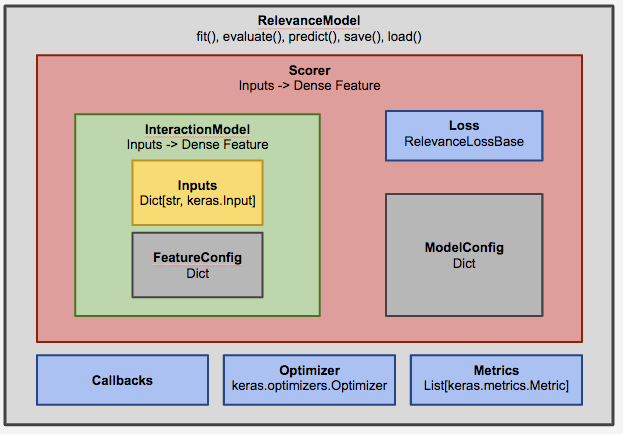

### Step 0: Define the Interaction Model

In [ ]:
from ml4ir.model.scoring.interaction_model import InteractionModel, UnivariateInteractionModel
from ml4ir.config.keys import TFRecordTypeKey

# Define custom feature layer ops
def get_categorical_embedding(input_feature, feature_info):
    """Embedding lookup for categorical features"""
    
    feature_layer_info = feature_info.get("feature_layer_info")
    return layers.Embedding(input_dim=feature_layer_info["args"]["vocabulary_size"],
                     output_dim=feature_layer_info["args"]["embedding_size"],
                     name="categorical_embedding_{}".format(feature_info.get("name")),
                 )(input_feature)

def signed_log(input_tensor, feature_info):
    """Signed log"""
    feature_layer_info = feature_info.get("feature_layer_info")
    return tf.expand_dims(
                tf.math.log(
                    tf.add(input_tensor,
                    tf.cast(tf.constant(feature_layer_info["args"]["shift"]),
                            tf.float32)
                          )
                ),
                axis=-1)

feature_layer_fns = {
    "custom_categorical_embedding": get_categorical_embedding,
    "signed_log": signed_log
}

interaction_model: InteractionModel = UnivariateInteractionModel(
                                            feature_config=feature_config,
                                            feature_layer_keys_to_fns=feature_layer_fns,
                                            tfrecord_type=TFRecordTypeKey.EXAMPLE)

### Step 1: Define the Scorer

In [ ]:
from ml4ir.model.scoring.scoring_model import ScorerBase, RelevanceScorer
from ml4ir.model.losses.loss_base import RelevanceLossBase
from tensorflow.keras import layers
from tensorflow.keras import losses

class MyCustomLoss(RelevanceLossBase):
    def get_loss_fn(self, **kwargs):
        """
        Define a sigmoid cross entropy loss
        Additionally can pass in record positions to handle positional bias

        """
        bce = losses.BinaryCrossentropy(reduction=losses.Reduction.SUM_OVER_BATCH_SIZE)
        mask = kwargs.get("mask")

        def _loss_fn(y_true, y_pred):
            # NOTE: Can use any of the metadata features to qualify your loss here
            return bce(y_true, y_pred)

        return _loss_fn

    def get_final_activation_op(self, output_name):
        return lambda logits, mask: layers.Activation("sigmoid", name=output_name)(logits)

scorer: ScorerBase = RelevanceScorer.from_model_config_file(
    model_config_file='/Users/ashish.srinivasa/search_relevance/ml4ir/python/ml4ir/config/default_model_config.yaml',
    interaction_model=interaction_model,
    loss=MyCustomLoss(),
    output_name="relevance_score")
    
logger.info(json.dumps(scorer.model_config, indent=4))

### Step 2: Define Metrics

In [ ]:
from tensorflow.keras import metrics as kmetrics

metrics = ['binary_accuracy', kmetrics.Precision(name='precision')]

### Step 3: Define Optimizer

In [ ]:
from tensorflow.keras.optimizers import Optimizer
from ml4ir.model.optimizer import get_optimizer
from ml4ir.config.keys import OptimizerKey

optimizer: Optimizer = get_optimizer(
                optimizer_key=OptimizerKey.ADAM,
                learning_rate=0.01,
                learning_rate_decay=0.94,
                learning_rate_decay_steps=1000,
                gradient_clip_value=50,
            )

### Now... let's put it all together

In [ ]:
from ml4ir.model.relevance_model import RelevanceModel
from ml4ir.config.keys import OptimizerKey

relevance_model = RelevanceModel(
        feature_config=feature_config,
        scorer=scorer,
        metrics=metrics,
        optimizer=optimizer,
        tfrecord_type=TFRecordTypeKey.EXAMPLE,
        output_name="relevance_score",
        logger=logger
    )

In [ ]:
relevance_model.fit(relevance_dataset, 
                    num_epochs=5, 
                    models_dir='/Users/ashish.srinivasa/search_relevance/model_training/test/models',
                    logs_dir='/Users/ashish.srinivasa/search_relevance/model_training/test/logs',
                    monitor_metric='val_binary_accuracy',
                    monitor_mode='max')

### Let's save the model(...and don't forget about serving signatures)

In [ ]:
relevance_model.save(
    models_dir='/Users/ashish.srinivasa/search_relevance/model_training/test/models',
    preprocessing_keys_to_fns=preprocessing_fns,
    required_fields_only=True)

### Reload the model for some predictions

In [ ]:
from ml4ir.config.keys import TFRecordTypeKey

relevance_model = RelevanceModel(
    feature_config=feature_config,
    tfrecord_type=TFRecordTypeKey.EXAMPLE,
    model_file='/Users/ashish.srinivasa/search_relevance/model_training/test/models/final/default/',
    logger=logger,
    output_name="relevance_score"
)

logger.info("Is Keras model? {}".format(isinstance(relevance_model.model, tf.keras.Model)))
logger.info("Is compiled? {}".format(relevance_model.is_compiled))

relevance_model.predict(test_dataset=relevance_dataset.test).sample(25)

### Let's see how the TFRecord serving signature works

In [ ]:
from tensorflow.keras import models as kmodels
from tensorflow import data

model = kmodels.load_model(
    '/Users/ashish.srinivasa/search_relevance/model_training/test/models/final/tfrecord/',
    compile=False)
infer_fn = model.signatures["serving_tfrecord"]

dataset = data.TFRecordDataset(
    glob.glob(os.path.join(CSV_DATA_DIR, "tfrecord", "test", "*.tfrecord")))
protos = next(iter(dataset.batch(10)))

logger.info("Example proto: \n{}".format(protos[0]))

logger.info("\n\n\nPredictions:")
logger.info(infer_fn(protos=protos))

### Why you should onboard your ML application to ml4ir today!

* Consistent code structure and modularization across projects
* Scalable TFRecord data pipeline
    * Every ML application shouldn’t have to reinvent the wheel especially when there is barely any documentation on this.
    * Consistent file I/O overall
* Consistent library versions across projects
    * Easily update versions and validate inference time impact, etc
* Common Flowsnake enablement
    * We can define _git.soma/MLConfigs_ to track and automatically build docker images through strata from ml4ir.
* Unified python ↔ JVM interoperability
    * Define integration tests
    * Allows us to build generic protobuf creation at runtime
* Common training abstraction
    * Callbacks : checkpointing, early stopping, tensorboard, etc
    * Consistent way to save models
        * allows us to have generic deployment code
* Shared metrics, losses, layers, etc.
* Shared feature processing and feature layers across ML models
    * long term: shared NLP toolkit, probability toolkit
    * short term: categorical, text embeddings
* Build models that can be trained with tight coupling:
    * transfer learning
    * shared embedding layers
    * multi task models



> ### This is just the `end of the beginning` and we would love to take new passengers on this journey!

![thanks](https://media.giphy.com/media/lD76yTC5zxZPG/giphy.gif)

                                                            .


                                                            .


                                                            .


                                                            .


                                                            .


                                                            .


                                                            .


                                                            .

<center>Psst... You can file github issues -> <a href="https://github.com/salesforce/ml4ir/issues">HERE!</a></center>

![shhh](https://media.giphy.com/media/xZvXaVgssJnu8/giphy.gif)